In [ ]:
# Cell 1 — Environment and Path Setup

import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf

# Mount Google Drive (if running in Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    print("Not running in Colab, skipping drive mount.")

# TensorFlow and GPU info
print("Python:", sys.version)
print("TensorFlow:", tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)
else:
    print("No GPU detected. Training will fall back to CPU.")

# Paths (using your actual dataset location)
DATASET_DIR = "/content/drive/MyDrive/CricVision/Shots"
print("\nDataset path:", DATASET_DIR)
print("Folders found:", os.listdir(DATASET_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
TensorFlow: 2.19.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Dataset path: /content/drive/MyDrive/CricVision/Shots
Folders found: ['drive', 'sweep', 'pullshot', 'legglance-flick']


In [ ]:
# Cell 2 — Build metadata DataFrame from folder structure

import pandas as pd

# Collect filepaths and labels
data = []
for cls in os.listdir(DATASET_DIR):
    cls_path = os.path.join(DATASET_DIR, cls)
    if os.path.isdir(cls_path):
        for file in os.listdir(cls_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                data.append({
                    "filename": file,
                    "filepath": os.path.join(cls_path, file),
                    "label": cls
                })

df = pd.DataFrame(data)
print(f"Total images found: {len(df)}")
print("Classes:", df['label'].unique())
print(df.head())


Total images found: 4723
Classes: ['drive' 'sweep' 'pullshot' 'legglance-flick']
          filename                                           filepath  label
0    drives165.png  /content/drive/MyDrive/CricVision/Shots/drive/...  drive
1    drives194.png  /content/drive/MyDrive/CricVision/Shots/drive/...  drive
2  drives1206.jpeg  /content/drive/MyDrive/CricVision/Shots/drive/...  drive
3    drives146.png  /content/drive/MyDrive/CricVision/Shots/drive/...  drive
4    drives200.png  /content/drive/MyDrive/CricVision/Shots/drive/...  drive


In [ ]:
# Cell 3 — Normalize labels, encode, and split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Normalize labels for consistency
df['label'] = df['label'].str.replace('-', '_')

# Encode labels numerically
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Train/validation split (80/20, stratified)
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_encoded'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Save label encoder for later use
os.makedirs("/content/drive/MyDrive/CricVision/shot_classification", exist_ok=True)
encoder_path = "/content/drive/MyDrive/CricVision/shot_classification/label_encoder.pkl"
joblib.dump(le, encoder_path)
print("Label encoder saved to:", encoder_path)


Label mapping: {'drive': np.int64(0), 'legglance_flick': np.int64(1), 'pullshot': np.int64(2), 'sweep': np.int64(3)}
Training samples: 3778
Validation samples: 945
Label encoder saved to: /content/drive/MyDrive/CricVision/shot_classification/label_encoder.pkl


In [ ]:
# Cell 4 — Build TensorFlow data pipeline

from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Augmentations for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name="augmentation")

# Load and preprocess function
def load_image(path, label_id):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label_id

# Dataset builder
def make_ds(df, training=True):
    paths = df["filepath"].values
    labels = df["label_encoded"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.shuffle(2048, seed=42, reshuffle_each_iteration=True)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Create datasets
train_ds = make_ds(train_df, training=True)
val_ds = make_ds(val_df, training=False)

# Sanity check
for images, labels in train_ds.take(1):
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)


Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


In [ ]:
# Cell 5 — Model construction

from tensorflow import keras
from tensorflow.keras import layers

# Load EfficientNetB0 backbone
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg"
)

# Optionally freeze some layers (you can unfreeze later for fine-tuning)
for layer in base_model.layers:
    layer.trainable = True  # set to False for transfer learning warm-up

# Build model
inputs = layers.Input(shape=(224, 224, 3))
x = keras.applications.efficientnet.preprocess_input(inputs)
x = base_model(x, training=True)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs, outputs)

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top2_acc")]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
# Cell 6 — Training setup and execution

from tqdm.keras import TqdmCallback
import json

# Verify GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU:", gpus[0])
else:
    print("No GPU detected, training on CPU.")

# File save paths
MODEL_OUT = "/content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras"
HISTORY_JSON = "/content/drive/MyDrive/CricVision/shot_classification/shot_classifier_history.json"

# Callbacks
ckpt = keras.callbacks.ModelCheckpoint(
    MODEL_OUT,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

es = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=5,
    restore_best_weights=True
)

rlr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

# tqdm progress bar
tqdm_callback = TqdmCallback(verbose=1)

# Train
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[ckpt, es, rlr, tqdm_callback],
    verbose=0  # tqdm handles display
)

# Save training history
with open(HISTORY_JSON, "w") as f:
    json.dump(history.history, f)

print("\nBest model saved to:", MODEL_OUT)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Epoch 1: val_accuracy improved from -inf to 0.21270, saving model to /content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras

Epoch 2: val_accuracy improved from 0.21270 to 0.28360, saving model to /content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras

Epoch 3: val_accuracy improved from 0.28360 to 0.29841, saving model to /content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras

Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 4: val_accuracy improved from 0.29841 to 0.73439, saving model to /content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras

Epoch 5: val_accuracy improved from 0.73439 to 0.91958, saving model to /content/drive/MyDrive/CricVision/shot_classification/shot_classifier.keras

Epoch 6: val_accuracy did not improve from 0.91958

Epoch 7: val_accuracy improved from 0.91958 to 0.95873, saving model to /content/drive/MyDrive/CricVision/shot_classification/sh

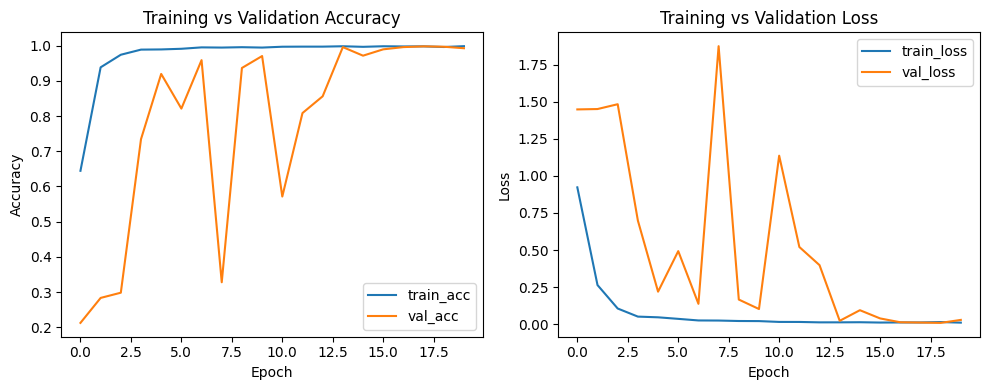


Classification Report:
                 precision    recall  f1-score   support

          drive       1.00      1.00      1.00       245
legglance_flick       0.99      1.00      1.00       224
       pullshot       1.00      1.00      1.00       252
          sweep       1.00      1.00      1.00       224

       accuracy                           1.00       945
      macro avg       1.00      1.00      1.00       945
   weighted avg       1.00      1.00      1.00       945



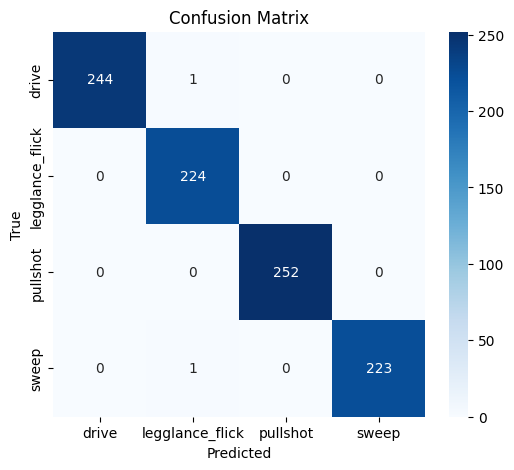

In [ ]:
# Cell 7 — Plot training curves and evaluate the model

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Plot accuracy and loss
def plot_curves(history):
    plt.figure(figsize=(10, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history["accuracy"], label="train_acc")
    plt.plot(history["val_accuracy"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training vs Validation Accuracy")

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history["loss"], label="train_loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")

    plt.tight_layout()
    plt.show()

plot_curves(history.history)

# Evaluate the best model
best_model = keras.models.load_model(MODEL_OUT)

# Prepare validation data
val_labels = val_df["label_encoded"].values
val_paths = val_df["filepath"].values

# Predict on validation set
y_pred = []
y_true = []

for path, true_label in zip(val_paths, val_labels):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.expand_dims(img, 0)
    preds = best_model.predict(img, verbose=0)
    y_pred.append(np.argmax(preds))
    y_true.append(true_label)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(le.classes_)))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(le.classes_),
            yticklabels=list(le.classes_))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
